# Imports

In [1]:
import os
import numpy as np
import numpy
from PyMieSim.mesh import FibonacciMesh
from scipy.interpolate import RectSphereBivariateSpline, interp1d, interp2d, griddata
from PyMieSim.tools.directories import lp_mode_path
import matplotlib.pyplot as plt
from pathlib import Path

import fibermodes
from fibermodes import FiberFactory, Mode, ModeFamily, Wavelength, PSimulator

# Function definition

In [131]:
def rescale_complex(array, sampling):
    scale = sampling / array.shape[0]

    array_real = ndimage.interpolation.zoom(
        input=array.real,
        zoom=(scale),
        order = 2
    )

    array_imag = ndimage.interpolation.zoom(
        input=array.imag,
        zoom=(scale),
        order = 2
    )

    return array_real + 1j * array_imag


def rotate_complex(array: numpy.ndarray, rotation: float) -> numpy.ndarray:
    array_real =  ndimage.rotate(array.real, rotation, reshape=False)
    array_imag =  ndimage.rotate(array.imag, rotation, reshape=False)
    return array_real + 1j * array_imag


def load_structured_mode(mode_number: str, sampling: int = 500) -> numpy.ndarray:
    n, m = mode_number_string_to_tuple(mode_number=mode_number)

    filename = f'LP{n}{m}/structured_{sampling}.npy'

    file_directory = lp_mode_path.joinpath(filename)

    if not file_directory.exists():
        raise ValueError( f'Could not load file: {file_directory}' )

    return np.load(file_directory)

def spherical_to_cartesian(phi: numpy.ndarray, theta: numpy.ndarray, r: numpy.ndarray = None) -> tuple:
    if r is None: r = numpy.ones(phi.shape)
    x = r * np.cos(phi) * np.cos(theta)
    y = r * np.cos(phi) * np.sin(theta)
    z = r * np.sin(phi)
    return x, y, z


def get_spherical_mesh(sampling: int, max_angle: float) -> tuple:
    radius_max = 100
    x, y = np.mgrid[
        -radius_max: radius_max: complex(sampling),
        -radius_max: radius_max: complex(sampling)
    ]

    z = x * 0 + radius_max / np.tan(max_angle)

    _, theta, phi = cartesian_to_spherical(x, y, z)

    return phi, theta

def cartesian_to_spherical(x: numpy.ndarray, y: numpy.ndarray, z: numpy.ndarray) -> tuple:
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arcsin(z/r)
    phi = np.arctan2(y, x)
    return r, phi, theta


def mode_number_string_to_tuple(mode_number: str) -> tuple:
    return numpy.asarray(mode_number.split('-')).astype(int)

def get_unstructured_field(mode_number: str, sampling, rotation=0, structured=False):
    mode_field = load_structured_mode(mode_number=mode_number)

    if rotation !=0: mode_field = rotate_complex(mode_field, rotation)

    if structured: return mode_field

    Phi, Theta = get_spherical_mesh(
        sampling=mode_field.shape[0],
        max_angle=0.5
    )

    mesh = FibonacciMesh(
        max_angle=0.5,
        sampling=sampling,
        phi_offset=0,
        gamma_offset=0
    )

    interpolation_real = Interpolator2D(
        values=mode_field.ravel().real,
        lats=Phi.ravel(),
        lons=Theta.ravel(),
        origin=(0,0),
        method_irreg='regularize'
    )

    interpolation_imaginary = Interpolator2D(
        values=mode_field.ravel().imag,
        lats=Phi.ravel(),
        lons=Theta.ravel(),
        origin=(0,0),
        method_irreg='regularize'
    )

    data_real = interpolation_real.interp(
        lat=mesh.get_phi(),
        lon=mesh.get_theta(),
        grid=False,
        squeeze=True,
        lat_deriv_order=0,
        lon_deriv_order=0
    )

    data_imaginary = interpolation_imaginary.interp(
        lat=mesh.get_phi(),
        lon=mesh.get_theta(),
        grid=False,
        squeeze=True,
        lat_deriv_order=0,
        lon_deriv_order=0
    )

    data = data_real + 1j * data_imaginary

    norm = np.sqrt(np.sum(np.abs(data)**2))

    return data / norm

def get_far_field_lp_mode(Mode, max_angle, sampling, rotation=0, Structured=False):
    mode_field = LoadLPMode(Mode)

    if rotation !=0: mode_field = rotate_complex(mode_field, rotation)

    if Structured: return mode_field

    Phi, Theta = get_spherical_mesh(
        sampling=mode_field.shape[0],
        max_angle=max_angle
    )

    mesh = FibonacciMesh(
        max_angle=max_angle,
        sampling=sampling,
        phi_offset=0,
        gamma_offset=0
    )

    interpolation_real = Interpolator2D(
        values=mode_field.ravel().real,
        lats=Phi.ravel(),
        lons=Theta.ravel(),
        origin=(0,0),
        method_irreg='regularize'
    )

    interpolation_imaginary = Interpolator2D(
        values=modeField.ravel().imag,
        lats=Phi.ravel(),
        lons=Theta.ravel(),
        origin=(0,0),
        method_irreg='regularize'
    )

    data_real = interpolation_real.interp(
        lat=mesh.get_phi(),
        lon=mesh.get_theta(),
        grid=False,
        squeeze=True,
        lat_deriv_order=0,
        lon_deriv_order=0
    )

    data_imaginary = interpolation_imaginary.interp(
        lat=mesh.get_phi(),
        lon=mesh.get_theta(),
        grid=False,
        squeeze=True,
        lat_deriv_order=0,
        lon_deriv_order=0
    )

    data = data_real + 1j * data_imaginary

    norm = np.sqrt(np.sum(np.abs(data)**2))

    return data / norm

def center_point(lat, lon):
    """ centerpoint of lat/lon bounds """
    if isinstance(lat, (list, tuple, np.ndarray)):
        return (np.min(lat) + np.max(lat)) / 2, (np.min(lon) + np.max(lon)) / 2

    return lat, lon

def latitude_longitude_to_radian(latitute, longitude):
    """ Convert latitute and longitude values from degrees to radians.

        The method expects the latitude to be in the range (-90,90) and
        the longitude to be in the range (-180,180).

        The output latitude is in the range (0,pi) and the output
        longitude is in the range (-pi,pi).

        Args:
            latitute: float or array
                latitude(s) in degrees from -90 to +90.
            longitude: float or array
                longitude(s) in degrees from -180 to +180.

        Returns:
            lat_rad: float or array
                latitude(s) in radians from 0 to pi.
            lon_rad: float or array
                longitude(s) in radians from -pi to pi.
    """
    factor = np.pi / 180
    lat_rad = (latitute + 90) * factor
    lon_rad = longitude * factor
    return lat_rad, lon_rad


def load_unstructured_lp_mode(mode_number: str, sampling: int = 100) -> numpy.ndarray:
    n, m = mode_number_string_to_tuple(mode_number=mode_number)

    filename = f'LP{n}{m}/unstructured_{sampling}.npy'

    file_directory = lp_mode_path.joinpath(filename)

    if not file_directory.exists():
        raise ValueError( f"File: {file_directory} does not exists. This specific LP mode with specific sampling might not be available" )

    return np.load(file_directory)


# Class definition

In [132]:
class Interpolator2D():
    """ Class for interpolating 2D (lat,lon) geospatial data.

        For irregular grids, the data values must be passed as a
        1d array and all three arrays (values, lats, lons) must have
        the same length.

        For regular grids, the data values must be passed as a
        2d array with shape (M,N) where M and N are the lengths
        of the latitude and longitude array, respectively.

        Attributes:
            values: 1d or 2d numpy array
                Values to be interpolated
            lats: 1d numpy array
                Latitude values
            lons: 1d numpy array
                Longitude values
            origin: tuple(float,float)
                Reference location (origo of XY coordinate system).
            method_irreg : {‘linear’, ‘nearest’, ‘cubic’, ‘regularize’}, optional
                Interpolation method used for irregular grids.
                Note that 'nearest' is usually significantly faster than
                the 'linear' and 'cubic'.
                If the 'regularize' is selected, the data is first mapped onto
                a regular grid by means of a linear interpolation (for points outside
                the area covered by the data, a nearest-point interpolation is used).
                The bin size of the regular grid is specified via the reg_bin argument.
            bins_irreg_max: int
                Maximum number of bins along either axis of the regular grid onto which
                the irregular data is mapped. Only relevant if method_irreg is set to
                'regularize'. Default is 2000.
    """
    def __init__(self, values, lats, lons, origin=None, method_irreg='regularize', bins_irreg_max=400):

        # compute coordinates of origin, if not provided
        if origin is None: origin = center_point(lats, lons)
        self.origin = origin

        # check if bathymetry data are on a regular or irregular grid
        reggrid = (np.ndim(values) == 2)

        # convert to radians
        lats_rad, lons_rad = torad(lats, lons)

        # necessary to resolve a mismatch between scipy and underlying Fortran code
        # https://github.com/scipy/scipy/issues/6556
        if np.min(lons_rad) < 0: self._lon_corr = np.pi
        else: self._lon_corr = 0
        lons_rad += self._lon_corr

        # initialize lat-lon interpolator
        if reggrid: # regular grid
            if len(lats) > 2 and len(lons) > 2:
                self.interp_ll = RectSphereBivariateSpline(u=lats_rad, v=lons_rad, r=values)
            elif len(lats) > 1 and len(lons) > 1:
                z = np.swapaxes(values, 0, 1)
                self.interp_ll = interp2d(x=lats_rad, y=lons_rad, z=z, kind='linear')
            elif len(lats) == 1:
                self.interp_ll = interp1d(x=lons_rad, y=np.squeeze(values), kind='linear')
            elif len(lons) == 1:
                self.interp_ll = interp1d(x=lats_rad, y=np.squeeze(values), kind='linear')

        else: # irregular grid
            if len(np.unique(lats)) <= 1 or len(np.unique(lons)) <= 1:
                self.interp_ll = GridData2D(u=lats_rad, v=lons_rad, r=values, method='nearest')

            elif method_irreg == 'regularize':

                # initialize interpolators on irregular grid
                if len(np.unique(lats)) >= 2 and len(np.unique(lons)) >= 2: method='linear'
                else: method = 'nearest'
                gd = GridData2D(u=lats_rad, v=lons_rad, r=values, method=method)
                gd_near = GridData2D(u=lats_rad, v=lons_rad, r=values, method='nearest')

                # determine bin size for regular grid
                lat_diffs = np.diff(np.sort(np.unique(lats)))
                lat_diffs = lat_diffs[lat_diffs > 1e-4]
                lon_diffs = np.diff(np.sort(np.unique(lons)))
                lon_diffs = lon_diffs[lon_diffs > 1e-4]
                bin_size = (np.min(lat_diffs), np.min(lon_diffs))

                # regular grid that data will be mapped to
                lats_reg, lons_reg = self._create_grid(lats=lats, lons=lons, bin_size=bin_size, max_bins=bins_irreg_max)

                # map to regular grid
                lats_reg_rad, lons_reg_rad = latitude_longitude_to_radian(lats_reg, lons_reg)
                lons_reg_rad += self._lon_corr
                vi = gd(theta=lats_reg_rad, phi=lons_reg_rad, grid=True)
                vi_near = gd_near(theta=lats_reg_rad, phi=lons_reg_rad, grid=True)
                indices_nan = np.where(np.isnan(vi))
                vi[indices_nan] = vi_near[indices_nan]

                # initialize interpolator on regular grid
                self.interp_ll = RectSphereBivariateSpline(u=lats_reg_rad, v=lons_reg_rad, r=vi)

            else:
                self.interp_ll = GridData2D(u=lats_rad, v=lons_rad, r=values, method=method_irreg)

        # store data used for interpolation
        self.lat_nodes = lats
        self.lon_nodes = lons
        self.values = values



    def interp(self, lat, lon, grid=False, squeeze=True, lat_deriv_order=0, lon_deriv_order=0):
        """ Interpolate using spherical coordinate system (latitude-longitude).

            lat and lot can be floats or arrays.

            If grid is set to False, the interpolation will be evaluated at
            the coordinates (lat_i, lon_i), where lat=(lat_1,...,lat_N)
            and lon=(lon_1,...,lon_N). Note that in this case, lat and
            lon must have the same length.

            If grid is set to True, the interpolation will be evaluated at
            all combinations (lat_i, lon_j), where lat=(lat_1,...,lat_N)
            and lon=(lon_1,...,lon_M). Note that in this case, the lengths
            of lat and lon do not have to be the same.

            Derivates are given per radians^n, where n is the overall
            derivative order.

            Args:
                lat: float or array
                    latitude of the positions(s) where the interpolation is to be evaluated
                lon: float or array
                    longitude of the positions(s) where the interpolation is to be evaluated
                grid: bool
                    Specify how to combine elements of lat and lon. If lat and lon have different
                    lengths, specifying grid has no effect as it is automatically set to True.
                lat_deriv_order: int
                    Order of latitude-derivative
                lon_deriv_order: int
                    Order of longitude-derivative

            Returns:
                zi: Interpolated values (or derivates)
        """
        lat = np.squeeze(np.array(lat))
        lon = np.squeeze(np.array(lon))
        lat_rad, lon_rad = latitude_longitude_to_radian(lat, lon)
        lon_rad += self._lon_corr

        if isinstance(self.interp_ll, interp2d):
            zi = self.interp_ll.__call__(x=lat_rad, y=lon_rad, dx=lat_deriv_order, dy=lon_deriv_order)
            if grid: zi = np.swapaxes(zi, 0, 1)
            if not grid and np.ndim(zi) == 2: zi = np.diagonal(zi)

        elif isinstance(self.interp_ll, interp1d):
            if len(self.lat_nodes) > 1:
                zi = self.interp_ll(x=lat_rad)
            elif len(self.lon_nodes) > 1:
                zi = self.interp_ll(x=lon_rad)

        else:
            zi = self.interp_ll.__call__(theta=lat_rad, phi=lon_rad, grid=grid, dtheta=lat_deriv_order, dphi=lon_deriv_order)

        if squeeze:
            zi = np.squeeze(zi)

        if np.ndim(zi) == 0 or (np.ndim(zi) == 1 and len(zi) == 1):
            zi = float(zi)

        return zi


    def _create_grid(self, lats, lons, bin_size, max_bins):
        """ Created regular lat-lon grid with uniform spacing that covers
            a set of (lat,lon) coordinates.

            Args:
                lats: numpy.array
                    Latitude values in degrees
                lons: numpy.array
                    Longitude values in degrees
                bin_size: float or tuple(float,float)
                    Lat and long bin size
                max_bins: int
                    Maximum number of bins along either axis

            Returns:
                : numpy.array, numpy.array
                    Latitude and longitude values of the regular grid
        """
        if isinstance(bin_size, (int,float)): bin_size = (bin_size, bin_size)
        res = []
        for v,dv in zip([lats,lons], bin_size):
            v_min = np.min(v) - dv
            v_max = np.max(v) + dv
            num = max(3, int((v_max - v_min) / dv) + 1)
            num = min(max_bins, num)
            v_reg = np.linspace(v_min, v_max, num=num)
            res.append(v_reg)

        return tuple(res)
    
class GridData2D():
    """ Interpolation of data on a two-dimensional irregular grid.

        Essentially, a wrapper function around scipy's interpolate.griddata.

        https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.interpolate.griddata.html

        An alternative to griddata could be Rbf, as discussed here:

        https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy

        Attributes:
            u: 1d numpy array
                data points 1st coordinate
            v: 1d numpy array
                data points 2nd coordinate
            r: 1d numpy array
                data values
            method : {‘linear’, ‘nearest’, ‘cubic’}, optional

    """

    def __init__(self, u, v, r, method='linear'):
        self.uv = np.array([u,v]).T
        self.r = r
        self.method = method


    def __call__(self, theta, phi, grid=False, dtheta=0, dphi=0):
        """ Interpolate data

            theta and phi can be floats or arrays.

            If grid is set to False, the interpolation will be evaluated at
            the positions (theta_i, phi_i), where theta=(theta_1,...,theta_N) and
            phi=(phi_1,...,phi_N). Note that in this case, theta and phi must have
            the same length.

            If grid is set to True, the interpolation will be evaluated at
            all combinations (theta_i, phi_j), where theta=(theta_1,...,theta_N) and
            phi=(phi_1,...,phi_M). Note that in this case, the lengths of theta
            and phi do not have to be the same.

            Note: Interpolation of derivates not yet implemented; dtheta > 0 or dphi > 0
            will result in AssertionError.

            Args:
                theta: float or array
                   1st coordinate of the points where the interpolation is to be evaluated
                phi: float or array
                   2nd coordinate of the points where the interpolation is to be evaluated
                grid: bool
                   Specify how to combine elements of theta and phi.
                dtheta: int
                    Order of theta-derivative
                dphi: int
                    Order of phi-derivative

            Returns:
                ri: Interpolated values
        """
        assert dtheta + dphi == 0, "Interpolation of derivatives not implemented for irregular grids"

        if grid: theta, phi, M, N = self._meshgrid(theta, phi)

        pts = np.array([theta,phi]).T
        ri = griddata(self.uv, self.r, pts, method=self.method)


        if grid:
            ri = np.reshape(ri, newshape=(N,M))
            ri = np.swapaxes(ri, 0, 1)

        return ri

    def _meshgrid(self, theta, phi):
        """ Create grid

            Args:
                theta: 1d numpy array
                   1st coordinate of the points where the interpolation is to be evaluated
                phi: 1d numpy array
                   2nd coordinate of the points where the interpolation is to be evaluated

            Returns:
                theta, phi: 2d numpy array
                    Grid coordinates
                M, N: int
                    Number of grid values
        """
        M = 1
        N = 1
        if np.ndim(theta) == 1: M = len(theta)
        if np.ndim(phi) == 1: N = len(phi)
        theta, phi = np.meshgrid(theta, phi)
        theta = theta.flatten()
        phi = phi.flatten()
        return theta, phi, M, N


# Main functions definition

In [159]:
def create_structured_lp_mode(mode_number_list: list, sampling: int = 500) -> None:
    for mode_number in mode_number_list:
        print(f'Generating structured mode LP {mode_number} with a sampling of {sampling}x{sampling}')

        n, m = numpy.asarray(mode_number.split('-')).astype(int)

        file_directory = lp_mode_path.joinpath(f"LP{n}{m}")

        if not file_directory.exists():
            os.makedirs(file_directory)

        filename = file_directory.joinpath(f"structured_{sampling}.npy")

        factory = FiberFactory()

        he11 = Mode(ModeFamily.LP, n, m)

        factory.addLayer(
            pos=0, 
            name="clad", 
            geometry="StepIndex", 
            index=1.4444, 
            radius=62.5
        )

        factory.addLayer(
            pos=0, 
            name="core", 
            geometry="StepIndex", 
            radius=20e-6, 
            index=1.474
        )

        fiber = factory[0]

        sim = PSimulator(
            factory, 
            [1550e-9], 
            vectorial=False, 
            scalar=True, 
            numax=6, 
            mmax=2
        )

        field = fibermodes.field.Field(
            fiber, 
            mode=he11, 
            wl=Wavelength(1550e-9), 
            r=25e-6, 
            np=sampling
        )

        np.save(
            file=filename, 
            arr=field.Ex()
        )


def create_unstructured_lp_mode(mode_number_list: list, sampling_list: list) -> None:
    for mode_number in mode_number_list:
        n, m = mode_number_string_to_tuple(mode_number=mode_number)
        
        for sampling in sampling_list:
            print(f'Generating unstructured modes: LP{n}{m} | Sampling: {sampling}')
            
            mode_field = get_unstructured_field(
                mode_number=mode_number,
                sampling=sampling,
                rotation=0
            )

            mesh = FibonacciMesh(
                max_angle=0.3,
                sampling=sampling,
                phi_offset=0,
                gamma_offset=0
            )


            x, y, z = spherical_to_cartesian(mesh.get_phi(), mesh.get_theta())

            np.save(
                file=f'./LP{n}{m}/unstructured_{sampling}', 
                arr=mode_field
            )

In [ ]:
# mode_number_list = [
#     '0-1', '0-2', '0-3', '0-4', 
#     '1-1', '1-2', '1-3', '1-4', 
#     '2-1', '2-2', '2-3', '2-4', 
#     '3-1', '3-2', '3-3', '3-4', 
#     '4-1', '4-2', '4-3', 
#     '5-1', '5-2'
# ]

# create_structured_lp_mode(
#     mode_number_list=mode_number_list,
#     sampling=500
# )




sampling_list = [
    100, 200, 300, 400, 500, 1000, 1500, 2000
]

create_unstructured_lp_mode(
    mode_number_list=mode_number_list,
    sampling_list=sampling_list
)

Generating unstructured modes: LP01 | Sampling: 100
Generating unstructured modes: LP01 | Sampling: 200
Generating unstructured modes: LP01 | Sampling: 300
Generating unstructured modes: LP01 | Sampling: 400
Generating unstructured modes: LP01 | Sampling: 500
Generating unstructured modes: LP01 | Sampling: 1000
Generating unstructured modes: LP01 | Sampling: 1500
Generating unstructured modes: LP01 | Sampling: 2000
Generating unstructured modes: LP02 | Sampling: 100
Generating unstructured modes: LP02 | Sampling: 200
Generating unstructured modes: LP02 | Sampling: 300
Generating unstructured modes: LP02 | Sampling: 400
Generating unstructured modes: LP02 | Sampling: 500
Generating unstructured modes: LP02 | Sampling: 1000
Generating unstructured modes: LP02 | Sampling: 1500
Generating unstructured modes: LP02 | Sampling: 2000
Generating unstructured modes: LP03 | Sampling: 100
Generating unstructured modes: LP03 | Sampling: 200
Generating unstructured modes: LP03 | Sampling: 300
Genera

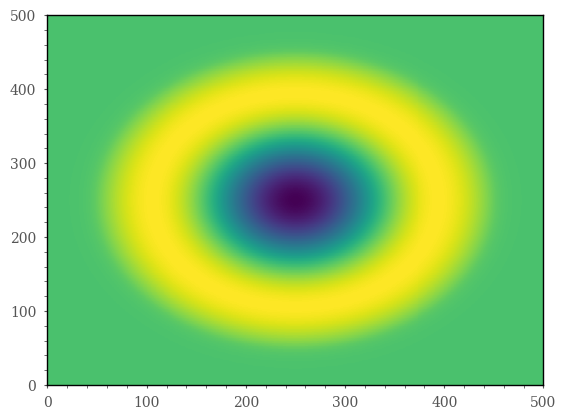

In [165]:
plt.figure()

field = np.load(lp_mode_path.joinpath('LP02/structured_500.npy'))

plt.pcolormesh(field)

plt.show()

True